# ML-7. Валидация данных и оценка модели
## Юнит 4. Основные алгоритмы машинного обучения. Часть I 
### Skillfactory: DST-10
---
### 7.2. Разбиение выборки
---
Разбиение выборки — это разделение имеющихся данных на несколько частей для проведения процессов обучения и валидации алгоритма МО так, что оба процесса выполнялись на полностью независимых наборах данных.  
Какие бывают выборки:  
*Обучающая* — подмножество данных, на котором мы обучаем модель.  
*Валидационная* — подмножество данных, на котором мы валидируем модель, то есть, проверяем промежуточные результаты. Выборка нужна для проверки модели.  
*Тестовая* — подмножество данных, на котором мы тестируем модель после проверки всевозможных гипотез.  
Обучаем на обучающей выборке: модель явно затачивается под обучающую выборку. Валидируем на валидационной и подкручиваем параметры модели: модель неявно затачивается под валидационную выборку. Тестовая выборка имитирует тестирование модели в реальных условиях.  

Как разбить выборку?  
- сomplete CV — полный скользящий контроль.  В данном случае оценка строится во всем возможным разбиениям. Важно упомянуть этот метод, однако стоит понимать, что даже при малых размерах длины обучающей выборки число выборки очень большое, и это затрудняет практическое применение данного метода. Полный скользящий контроль используют в теоретических исследованиях или в тех случаях (довольно редких), когда удается вывести вычислительную формулу, позволяющую реализовать вычисления. К примеру, для метода k ближайших соседней такая формула известна, но все же этот метод разбиения используется на практике крайне редко.  

- hold-out — отложенная выборка.  Разбиваем выборку на обучающую, валидационную и, по желанию, на тестовую выборки. Обычно в соотношении 60/40 или 70/30, вместе с тестовой — 60/20/20 или 70/15/15. Данный метод чаще всего применяется в случае больших датасетов в силу того, что требует значительно меньше вычислительных мощностей, чем другие методы. Однако важно помнить, что оценка в этом методе сильно зависит от разбиения. Это плохо, так как оценка должна в первую очередь характеризовать сам алгоритм обучения, а не способ разбиения.

- k-fold — cross-validation, перекрёстная валидация. 
  1. Разбиваем выборку на k частей.
  1. Повторяем k раз: обучаем на k-1 частях, валидируем на оставшейся части.
  1. На каждой итерации валидируем на части данных, на которой ещё не валидировали.
  1. Усредняем значения метрики.  

 Позволяет сделать оценку качества более робастной — устойчивой к помехам.
Чаще всего k имеет значение 10 (или 5 в случае маленьких выборок).

- t×k-fold кросс-валидация. Процедура выполняется t раз. Обучающая выборка случайным образом разбивается на k непересекающихся, одинаковых по объему частей. Производится k интераций. На каждой итерации происходит k-fold-разбиение. По сути, такой тип валидации — это k-fold валидация, которая повторяется t раз. Такой способ контроля обладает всеми преимуществами k-fold-валидации, но при этом добавляется возможность увеличивать число разбиений.

- leave-one-out — отложенный пример. Предельный случай k-fold, при котором k равняется размеру всей выборки:
  1. Выбираем пример для валидации, обучаем на всех остальных.
  1. Выбираем пример для валидации, который ещё не видели, возвращаемся в пункт 1.  
  
 Частный случай leave-P-out, при котором нужно перебрать все способы выбора P-элементов из выборки.  Большим недостатком данного метода является то, что он очень ресурсозатратен. Однако нельзя утверждать, что он вообще не используется. В некоторых методах обучения вычисление LOO получается заметно ускорить, и его использование становится возможным.

### 7.3 Разбиение выборки. Практика
---

In [1]:
import pandas as pd
import os
print(os.listdir('./data/'))
PATH_to_file = './data/'

['train.csv']


In [14]:

# Воспользуемся встроенным датасетом, который содержит информацию об опухолях груди:
from sklearn.datasets import load_iris # подгружаем датасет
data_iris = load_iris()

# скопируем данные
df_iris = pd.DataFrame(data_iris.data)
# имена столбцов датафрейма задаем, в соответствии с именами переменных:
df_iris.columns = data_iris.feature_names
# добавляем столбец с целевой переменной:
df_iris['target'] = data_iris.target
# для наглядности добавляем столбец с сортами:
df_iris['name'] = df_iris.target.apply(lambda x : data_iris.target_names[x])
# Смотрим, что получилось:
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [2]:
# У нас есть четыре признака, относящиеся к размерам цветка, и классы. На первом этапе мы разобьём выборку на две части: тренировочную и валидационную, а позже рассмотрим, как добавить тестовую. Воспользуемся методом train_test_split() из библиотеки sklearn:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(df_iris, test_size=0.15, shuffle=True)
# параметр shuffle = необходимо перемешать

print('Размер исходной выборки: {}\nРазмер тренировочной выборки: {}\nРазмер валидационной выборки: {}'
      .format(df_iris.shape, train.shape, valid.shape)
)

Размер исходной выборки: (150, 6)
Размер тренировочной выборки: (127, 6)
Размер валидационной выборки: (23, 6)


In [3]:
# Теперь визуализируем наше разбиение с помощью специального метода:
from itertools import zip_longest
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

def visualize_train_valid_counts(init_data, d_class, train, valid, test=[]):
    width = 0.2

    plt.figure(figsize=(12, 6))
    ax = plt.subplot(111)

    classes = list(init_data[d_class].value_counts().index)
    x = np.array(classes)

    ax.bar(x - width, list(init_data[d_class].value_counts()[classes]*2), width, color='r', label='Исходные данные')
    height_bar1 = [i * 2 for i in list(train[d_class].value_counts()[classes])]
    ax.bar(x, height_bar1, width, color='g', label='Тренировочная выборка')
    height_bar2 = [i * 2 for i in list(valid[d_class].value_counts()[classes])]
    ax.bar(x, height_bar2, width, bottom=height_bar1, color='b', label='Валидационная выборка')
    if len(test) > 0:
        height_bar3 = [i * 2 for i in list(test[d_class].value_counts()[classes])]
        sum_bar1_2 = [sum(i) for i in zip_longest(height_bar1, height_bar2, fillvalue=0)]
        ax.bar(x, height_bar3, width, bottom=sum_bar1_2, color='y', label='Тестовая выборка')

    ax.set_ylim([0, 140])
    plt.xticks(x - width / 2, classes, fontsize=20)
    plt.yticks(fontsize=15)
    plt.ylabel('Процент заполнения', fontsize=20)
    plt.minorticks_on()
    plt.grid(which='major', color='r')
    plt.grid(which='minor', linestyle=':', color='k')
    plt.legend(fontsize=12)

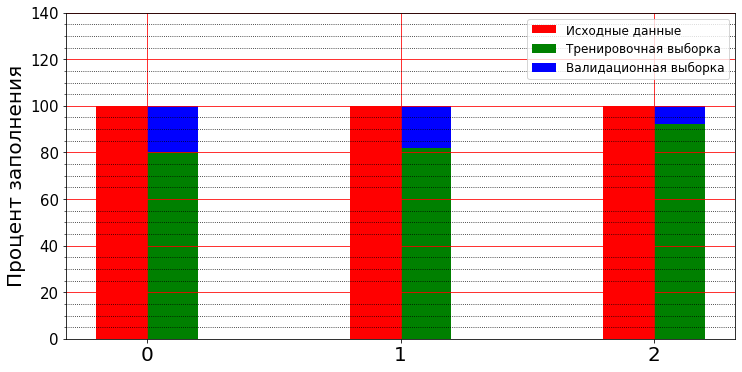

In [4]:
visualize_train_valid_counts(df_iris,'target', train, valid)

У нас три класса цветков, в каждом из которых получилось разное количество примеров с выборками, в третьем примере значительно больше примеров на валидационной выборке. Получилось неравномерное распределение классов после разбиения, так как мы не учли доли классов.

Проблема решается с помощью stratified разбиения или стратифицированного разбиения. В библиотеке sklearn есть нужный нам класс StratifiedShuffleSplit:

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15)
train_indices, valid_indices = [split for split in sss.split(df_iris.iloc[:, :4], df_iris.iloc[:, 4])][0]
s_train = df_iris.iloc[train_indices]
s_valid = df_iris.iloc[valid_indices]

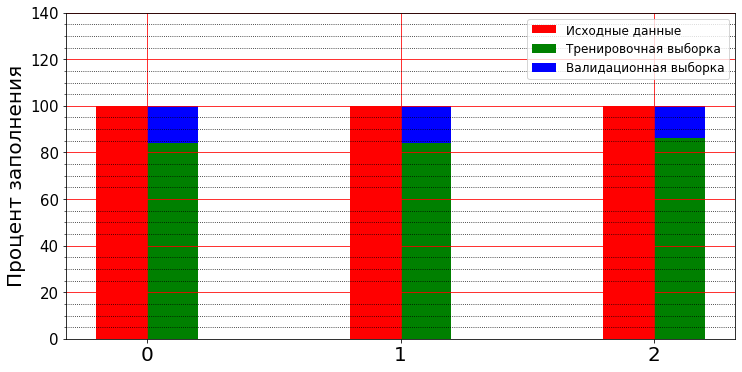

In [6]:
visualize_train_valid_counts(df_iris,'target', s_train, s_valid)

В класс мы передали количество разбиений, размер выборки и вызвали метод split() для более равномерного распределения. В результате разбиение получилось практически одинаковым.

---

Как разбить выборку на три части? Определить размер выборок и поделить дважды: сначала на тренировочную и остальное, затем остальное на валидационную и тестовую:

In [7]:
valid_frac = 0.15
test_frac = 0.15

# также test_size может принимать на вход кол-во необходимых строк
valid_count = int(valid_frac * df_iris.shape[0])
test_count = int(test_frac * df_iris.shape[0])

train, valid_test = train_test_split(df_iris, 
                                     test_size=valid_count+test_count)
valid, test = train_test_split(valid_test, test_size=test_count)

In [8]:
# проверим размерности
df_iris.shape, train.shape, valid_test.shape, valid.shape, test.shape

((150, 6), (106, 6), (44, 6), (22, 6), (22, 6))

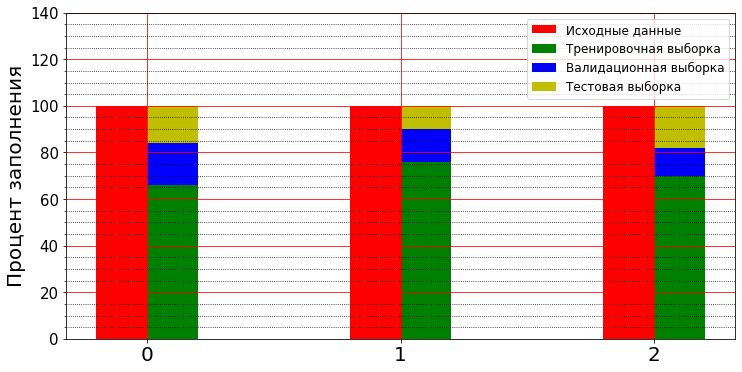

In [9]:
visualize_train_valid_counts(df_iris,'target', train, valid, test)

In [10]:
# пример разбиения на три части с помощью StratifiedShuffleSplit

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.30)
train_indices, valid_test_indices = [split for split in sss2.split(df_iris.iloc[:, :4], df_iris.iloc[:, 4])][0]
s_train = df_iris.iloc[train_indices]
s_valid_test = df_iris.iloc[valid_test_indices]

sss3 = StratifiedShuffleSplit(n_splits=1, test_size=0.5)
train_indices, valid_indices = [split for split in sss3.split(s_valid_test.iloc[:, :4], s_valid_test.iloc[:, 4])][0]
s_valid = s_valid_test.iloc[train_indices]
s_test = s_valid_test.iloc[valid_indices]

In [11]:
# проверим размерности
df_iris.shape, s_train.shape, s_valid_test.shape, s_valid.shape, s_test.shape

((150, 6), (105, 6), (45, 6), (22, 6), (23, 6))

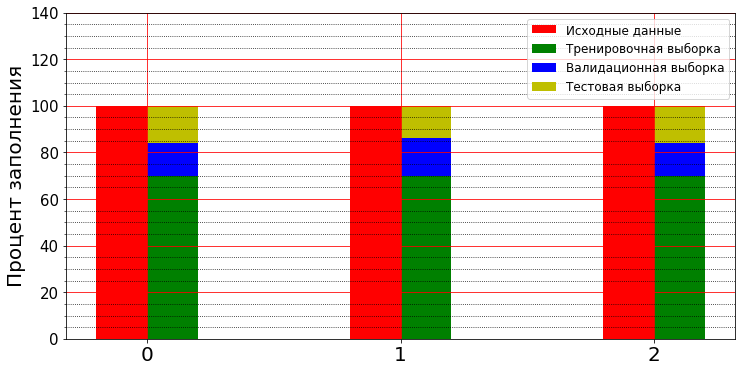

In [12]:
visualize_train_valid_counts(df_iris,'target', s_train, s_valid, s_test)

In [13]:
# Второй тип разбиения — k-fold, перекрёстная валидация. Сделаем k-fold разбиение данных, используя класс KFold:
from sklearn.model_selection import KFold

# shuffle=False исключает предварительное перемешивание примеров
kf = KFold(n_splits=3, shuffle=False)

for train_index, valid_index in kf.split(df_iris):
    print('train indices: {}\nvalid indices: {}'.format(train_index, valid_index))
    print('='*20)

train indices: [ 50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 147 148 149]
valid indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
train indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 

In [15]:
# Ещё один способ разбиения — leave-one-out, отложенный пример. Сделаем leave-one-out разбиение пяти примерах из исходных данных с помощью класса LeaveOneOut:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()

for train_index, valid_index in loo.split(df_iris[:5]):
    print('train indices: {}\nvalid indices: {}'.format(train_index, valid_index))
    print('='*20)

train indices: [1 2 3 4]
valid indices: [0]
train indices: [0 2 3 4]
valid indices: [1]
train indices: [0 1 3 4]
valid indices: [2]
train indices: [0 1 2 4]
valid indices: [3]
train indices: [0 1 2 3]
valid indices: [4]


### Задание 7.3.1
Загрузите данные train.csv, разделите выборку на обучающую и тестовую части в соотношении 70% на 30% без перемешивания. Найдите среднее значение для признака payment_amount и запишите его в переменную result. Обратите внимание, что среднее нужно считать по тестовой выборке.

***Ответ:***
```python
train, test = train_test_split(vis_data, test_size=0.3, shuffle=False)
result = test["payment_amount"].mean()
```

Полный код:  
```python
from sklearn.model_selection import train_test_split
vis_data = pd.read_csv('train.csv', encoding = 'ISO-8859-1')
train, test = train_test_split(vis_data, test_size=0.3, shuffle=False)
result = test["payment_amount"].mean()
```

In [23]:
# проверка кода
from sklearn.model_selection import train_test_split
df = pd.read_csv(PATH_to_file+'train.csv', encoding = 'ISO-8859-1')
train, test = train_test_split(df, test_size=0.3, shuffle=False)
result = test["payment_amount"].mean()

In [26]:
import glob
from chardet.universaldetector import UniversalDetector

detector = UniversalDetector()
for filename in glob.glob(PATH_to_file+'train.csv'):
    print (filename.ljust(60))
    detector.reset()
    for line in file(filename, 'rb'):
        detector.feed(line)
        if detector.done: break
    detector.close()
    print (detector.result)

./data/train.csv                                            


TypeError: '_io.TextIOWrapper' object is not callable

In [18]:
import chardet    
rawdata = open(PATH_to_file+'train.csv', "r").read()
result = chardet.detect(b'rawdata')
charenc = result['encoding']
print(charenc)

ascii


In [15]:
df = pd.read_csv(PATH_to_file+'train.csv', encoding = 'ascii')

In [17]:
df

,first


конец модуля